In [2]:
!pip install kaggle
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 97% 25.0M/25.7M [00:02<00:00, 20.0MB/s]
100% 25.7M/25.7M [00:02<00:00, 11.9MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [44]:
import numpy as np
import pandas as pd
import seaborn as sns

In [45]:
data = pd.read_csv('IMDB Dataset.csv')

In [46]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [47]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Enlever les balises HTML
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Enlever la ponctuation
    text = text.lower()  # Passage en minuscules
    text = text.strip()  # Enlever les espaces en trop
    tokens = text.split()  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Enlever les stopwords et lemmatisation
    return ' '.join(tokens)

data['review'] = data['review'].apply(clean_text)

# Tokenisation lemmatisation et padding

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

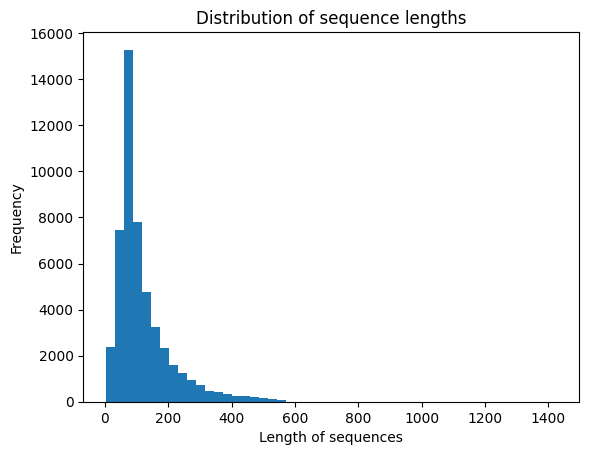

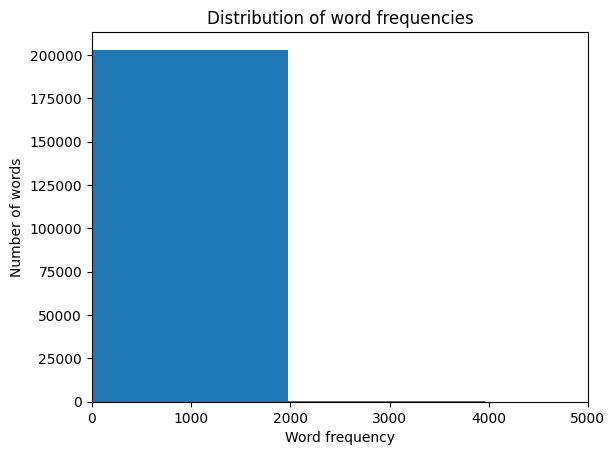

In [49]:
# Tokenisation et séquence des mots
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])

# Histogramme de la longueur des séquences de mots
seq_lengths = [len(seq) for seq in sequences]
plt.hist(seq_lengths, bins=50)
plt.xlabel('Length of sequences')
plt.ylabel('Frequency')
plt.title('Distribution of sequence lengths')
plt.show()

# Histogramme des fréquences des mots différents
word_counts = tokenizer.word_counts.values()
plt.hist(word_counts, bins=50)
plt.xlabel('Word frequency')
plt.ylabel('Number of words')
plt.title('Distribution of word frequencies')
plt.xlim([0, 5000])
plt.show()


In [50]:
# Compter la fréquence des mots
word_counts = tokenizer.word_counts

# Filtrer les mots ayant moins de 10 occurrences
filtered_word_counts = {word: count for word, count in word_counts.items() if count >= 5}
tokenizer.word_counts = filtered_word_counts

# Mettre à jour les index des mots dans le tokenizer après le filtrage
tokenizer.word_index = {word: i+1 for i, (word, count) in enumerate(filtered_word_counts.items())}

print(len(filtered_word_counts))

38690


In [51]:
max_words = 38690  # Ajuster en fonction de l'histogramme
max_len = 500  # Ajuster en fonction de l'histogramme

# Padding des séquences
X = pad_sequences(sequences, maxlen=max_len)

In [52]:
from sklearn.preprocessing import LabelEncoder

In [53]:
# Encodage des labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])

# Modèle LSTM

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [55]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

In [ ]:
# Définition du modèle LSTM
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # un neurone avec sigmoide
])

# Compilation du modèle
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Entraînement du modèle
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

In [ ]:
# Sauvegarde des poids du modèle
model_lstm.save('model_lstm_weights.h5')

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Évaluation du modèle
y_pred = model_lstm.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Seuil de 0.5 pour la classification binaire

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# Calcul des métriques de performance
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
specificity = tn / (tn + fp)  # Spécificité
sensitivity = recall  # Sensibilité est la même que le rappel (recall)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {recall}')
print(f'Specificity: {specificity}')
print(f'F1 Score: {f1}')

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Courbe ROC et AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
def clean_text_com(text):
    # Enlever les balises HTML
    text = re.sub(r'<.*?>', '', text)
    # Enlever la ponctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Passage en minuscules
    text = text.lower()
    # Enlever les espaces en trop
    text = text.strip()
    # Tokenization
    tokens = text.split()
    # Enlever les stopwords et lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Rejoindre les tokens en une seule chaîne de caractères
    cleaned_text = ' '.join(tokens)
    # Transformer le texte en séquence de tokens
    sequences = tokenizer.texts_to_sequences([cleaned_text])
    # Appliquer le padding pour obtenir une séquence de longueur fixe
    padded_sequence = pad_sequences(sequences, maxlen=100)  # Ajustez maxlen selon votre modèle
    return padded_sequence

def predict_sentiment(text):
    processed_text = clean_text_com(text)
    prediction = model_lstm.predict(processed_text)
    predicted_class = (prediction > 0.5).astype(int)
    sentiment = label_encoder.inverse_transform(predicted_class)
    return sentiment

In [ ]:
# Exemple d'utilisation
commentaire_positif = "This movie was absolutely amazing, I loved it!"
commentaire_negatif = "I hated this movie, it was terrible."
sentiment_positif = predict_sentiment(commentaire_positif)
sentiment_negatif = predict_sentiment(commentaire_negatif)
print(f"Le sentiment du commentaire positif est : {sentiment_positif}")
print(f"Le sentiment du commentaire negatif est : {sentiment_negatif}")

# LSTM avec attention

In [57]:
from tensorflow.keras.layers import Attention, Input, Flatten
from keras.models import Model

In [58]:
input_layer = Input(shape=(500,))
embedding_layer = Embedding(input_dim=max_words, output_dim=128)(input_layer)
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])

attention_layer = Flatten()(attention_layer)
output_layer = Dense(1, activation='sigmoid')(attention_layer)

model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)

In [59]:
# Compilation du modèle
model_lstm_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
# Entraînement du modèle
history_attention = model_lstm_attention.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
500/500 [==============================] - 68s 131ms/step - loss: 0.3727 - accuracy: 0.8251 - val_loss: 0.2908 - val_accuracy: 0.8855 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 41s 83ms/step - loss: 0.1690 - accuracy: 0.9371 - val_loss: 0.3170 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 31s 63ms/step - loss: 0.0775 - accuracy: 0.9716 - val_loss: 0.4469 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 28s 56ms/step - loss: 0.0427 - accuracy: 0.9856 - val_loss: 0.6932 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 25s 50ms/step - loss: 0.0264 - accuracy: 0.9916 - val_loss: 0.8816 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 6/100
500/500 [==============================] - 22s 45ms/step - loss: 0.0238 - accuracy: 0.9925 - val_loss: 0.7572 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 7/100
500/500 [==============================

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report

313/313 [==============================] - 3s 9ms/step
Accuracy: 0.8739
Precision: 0.8627112135176651
Recall (Sensitivity): 0.8916451676920024
Specificity: 0.8558758314855875
F1 Score: 0.8769395920757296


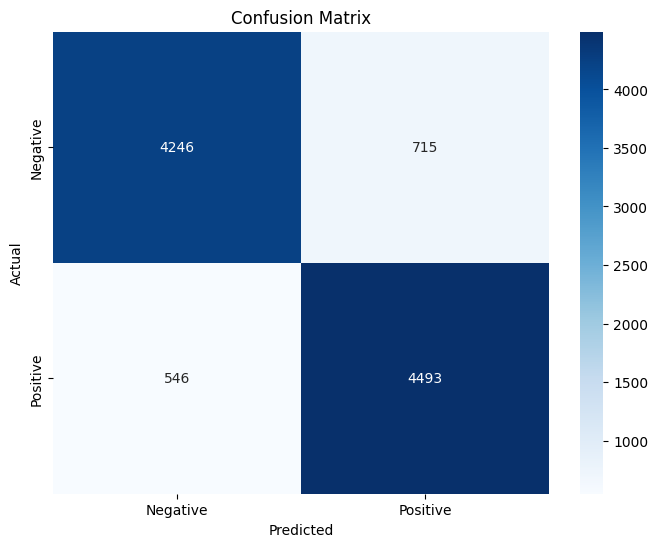

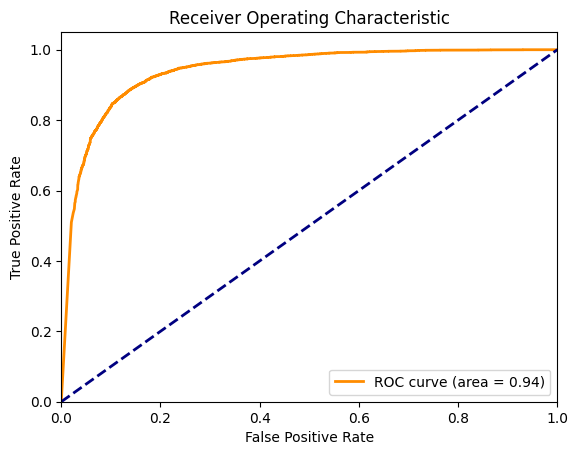

In [62]:
# Évaluation du modèle
y_pred = model_lstm_attention.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Seuil de 0.5 pour la classification binaire

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# Calcul des métriques de performance
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
specificity = tn / (tn + fp)  # Spécificité
sensitivity = recall  # Sensibilité est la même que le rappel (recall)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {recall}')
print(f'Specificity: {specificity}')
print(f'F1 Score: {f1}')

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Courbe ROC et AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
